# Explore here

In [1]:
# Librerías necesarias
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import XGBClassifier, cv, DMatrix
from sklearn.metrics import *
from imblearn.metrics import specificity_score
from collections import Counter

El Datasets de esta práctica ya ha sido procesado. Solo se incluye como referencia

# Datos de Entrenamiento y de Prueba

In [2]:
# Cargamos el dataset
df = pd.read_csv('../data/processed/df_clean.csv')

In [3]:
# Separamos las variables independientes de la variable dependiente
X = df.drop('Outcome', axis=1)
y = df['Outcome']

In [4]:
# Leemos los datos entrenados y visualizamos 
train_data = pd.read_csv("../data/processed/clean_train.csv")
test_data = pd.read_csv("../data/processed/clean_test.csv")

In [5]:
# Separamos nuestros datos de entrenamiento y prueba
X_train = train_data.drop(["y"], axis = 1)
y_train = train_data["y"]
X_test = test_data.drop(["y"], axis = 1)
y_test = test_data["y"]

# Métricas de Evaluación

In [6]:
def get_metrics(y_train, y_test, y_pred_train, y_pred_test):
    # Calcular métricas para el conjunto de entrenamiento
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_f1 = f1_score(y_train, y_pred_train)
    train_auc = roc_auc_score(y_train, y_pred_train)
    train_precision = precision_score(y_train, y_pred_train)
    train_recall = recall_score(y_train, y_pred_train)
    train_specificity = specificity_score(y_train, y_pred_train)

    # Calcular métricas para el conjunto de prueba
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_f1 = f1_score(y_test, y_pred_test)
    test_auc = roc_auc_score(y_test, y_pred_test)
    test_precision = precision_score(y_test, y_pred_test)
    test_recall = recall_score(y_test, y_pred_test)
    test_specificity = specificity_score(y_test, y_pred_test)

    # Calcular la diferencia entre métricas de entrenamiento y prueba
    diff_accuracy = train_accuracy - test_accuracy
    diff_f1 = train_f1 - test_f1
    diff_auc = train_auc - test_auc
    diff_precision = train_precision - test_precision
    diff_recall = train_recall - test_recall
    diff_specificity = train_specificity - test_specificity

    # Crear un DataFrame con los resultados
    metrics_df = pd.DataFrame([[train_accuracy, train_f1, train_auc, train_precision, train_recall, train_specificity],[test_accuracy, test_f1, test_auc, test_precision, test_recall, test_specificity],[diff_accuracy, diff_f1, diff_auc, diff_precision, diff_recall, diff_specificity]],
                              columns = ['Accuracy', 'F1', 'AUC', 'Precision', 'Recall', 'Specificity'],
                              index = ['Train','Test', 'Diferencia'])

    return metrics_df

# Boosting

In [7]:
class CustomBoosting:

  def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=10,
               min_samples_leaf=10, max_features=1.0, random_state=42):
        self.n_estimators = n_estimators  # Número de estimadores en el ensamble
        self.learning_rate = learning_rate  # Tasa de aprendizaje
        self.max_depth = max_depth  # Profundidad máxima de los árboles de decisión
        self.min_samples_leaf = min_samples_leaf  # Número mínimo de muestras por hoja
        self.max_features = max_features  # Proporción máxima de características a considerar en cada división
        self.random_state = random_state  # Semilla aleatoria para reproducibilidad
        self.estimadores = [] # Almacena los estimadores del ensamble

  def muestreo(self, X, y, pesos):
    
    # Semilla para replicar el experimento
    np.random.seed(self.random_state)
    
    # Selecciono lo indices que serán usados para generar la muestra
    indices = np.random.choice(X.shape[0], size=X.shape[0], p=pesos)
   
    return X[indices], y[indices]

  def get_error(self, y, y_pred, pesos):
    
    # Obtener las instancias mal clasificadas
    instancias_erroneas = (y!=y_pred)
    
    # Obtenemos los pesos de las instancias erróneamente clasificadas
    pesos_instancias_erroneas = pesos[instancias_erroneas]
    
    # Suma total del peso de las instancias erróneas
    suma_pesos_error = np.sum(pesos_instancias_erroneas)
    
    # Normalizamos el error para que tome un valor entre 0 y 1
    error_ponderado = suma_pesos_error / np.sum(pesos)
    
    return instancias_erroneas, error_ponderado

  def get_estimator_importance(self, error_ponderado):
    
    # Proporción de acierto frente al error
    return np.log((1-error_ponderado)/error_ponderado)*self.learning_rate
  
  def update_pesos(self, estimator_importance, instancias_erroneas, pesos):
    
    # Actualiza los pesos de las instancias para dar más importancia a las instancias mal clasificadas
    # incrementar de forma más específica los pesos de las instancias que fueron mal clasificadas,
    # mientras que disminuye las que fueron correctamente clasificadas, 
    # ajustando así de manera más efectiva la atención del modelo hacia las instancias que más necesita aprender.
    
    actualizacion_pesos = np.where(instancias_erroneas,
                                   np.exp(estimator_importance),
                                   np.exp(-estimator_importance))
    
    pesos = pesos * actualizacion_pesos  # Aplica la actualización a los pesos
    pesos = pesos / np.sum(pesos)  # Normaliza los pesos para que sumen 1, creando una distribución de probabilidad válida
    return pesos

  def fit(self, X, y):
    
    # Convertir a arrays numpy que son DataFrames
    if hasattr(X, 'values'):
            X = X.values
    if hasattr(y, 'values'):
            y = y.values
          
    # Inicializar los pesos de las instancias
    pesos = np.ones(len(X))/len(X)
    
    # Realizamos el entrenamiento de los estimadores
    for _ in range(self.n_estimators):
      
      # Realizamos un muestreo del dataset teniendo en cuenta el peso asociado a cada instancia
      X_sampled, y_sampled = self.muestreo(X, y, pesos)
      
      # Entrenamos el estimador con la versión muestreada
      estimador = DecisionTreeClassifier(
          max_depth=self.max_depth,
          min_samples_leaf=self.min_samples_leaf,
          max_features=self.max_features)
      estimador.fit(X_sampled, y_sampled)
      
      # Realizamos predicciones con el estimador entrenado      
      y_pred = estimador.predict(X)
      
      # Obtener el error cometido por el estimador
      instancias_erroneas, error_ponderado = self.get_error(y, y_pred, pesos)
      
      # Calcular la importancia del estimador
      estimator_importance = self.get_estimator_importance(error_ponderado)
      
      # Almacenar el estimador junto a su importancia
      self.estimadores.append((estimador, estimator_importance))
      
      # Actualizar los pesos de las instancias
      pesos = self.update_pesos(estimator_importance, instancias_erroneas, pesos)

  def predict(self, X):
    # Convertir a array numpy que es DataFrame
    if hasattr(X, 'values'):
            X = X.values
    
    # Inicializamos una variable donde almacenar las predicciones finales
    final_predictions = np.zeros(X.shape[0])
    
    # Para cada estimador del ensamblado
    for estimador, estimador_imp in self.estimadores:
      
      # Aplicar el estimador sobre los datos a predecir
      predicciones = estimador.predict(X)
      
      # Pondero las precciones
      preds_ponderada = predicciones*estimador_imp
      
      # Acumula las predicciones ponderadas
      final_predictions = final_predictions+preds_ponderada
      
    mean_val = np.mean(final_predictions)
    yhats = np.where(final_predictions<mean_val,0,1)
    return yhats

In [8]:
# Entrenamos el modelo de Boosting
modeloALG = CustomBoosting(n_estimators=10,
                    learning_rate=0.01,
                    max_depth=7,
                    min_samples_leaf=7,
                    max_features=X_train.shape[1]//2)
modeloALG.fit(X_train, y_train)

# Realizamos predicciones en el conjunto de entrenamiento y prueba
test_pred = modeloALG.predict(X_test)
train_pred = modeloALG.predict(X_train)

# Evaluamos el rendimiento del modelo
get_metrics(y_train, y_test, train_pred, test_pred)

,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,0.841105,0.788018,0.838641,0.750000,0.830097,0.847185
Test,0.758621,0.666667,0.774624,0.564516,0.813953,0.735294
Diferencia,0.082485,0.121352,0.064017,0.185484,0.016144,0.111891


# XGB

In [9]:
# Manejo de clases desbalanceadas
counter = Counter(y_train)
scale_pos_weight = counter[0] / counter[1] if counter[1] != 0 else 1

# Modelo XGB base
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42)

In [10]:
# Hiperparámetros para búsqueda
param_dist = {
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [1, 5, 10],
    'min_child_weight': [10, 15, 20],
    'scale_pos_weight': [scale_pos_weight]}

In [11]:
# RandomizedSearchCV para optimizar hiperparámetros
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    scoring='accuracy',
    cv=5,
    n_iter=20,
    n_jobs=-1,
    random_state=42)

# Entrenar la búsqueda de hiperparámetros
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning...
                                           num_parallel_tree=None,
                                           random_state=42, ...),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.3],
                                        'max_depth': [3, 5, 7, 9],
                                        'min_child_weight': [10, 15, 20],
                                        'reg_alpha': [0, 0.1, 0.5, 1],
                                        'reg_lambda': [1, 5, 10],
                                        'scale_pos_weight': [1.8106796116504855],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='accuracy')

In [12]:
# Mejor modelo encontrado
best_xgb = random_search.best_estimator_

In [13]:
# Validación cruzada con los mejores hiperparámetros
cv_results = xgb.cv(
    params=random_search.best_params_,
    dtrain=xgb.DMatrix(X_train, label=y_train),
    num_boost_round=200,
    nfold=5,
    metrics='logloss',
    early_stopping_rounds=10)

print("Resultados de validación cruzada:")
print(cv_results)

Resultados de validación cruzada:
    train-logloss-mean  train-logloss-std  test-logloss-mean  test-logloss-std
0             0.678944           0.001651           0.682399          0.004597
1             0.663079           0.002290           0.670520          0.003624
2             0.647238           0.002941           0.657655          0.005686
3             0.633899           0.003764           0.646796          0.005997
4             0.622810           0.004418           0.639208          0.006617
..                 ...                ...                ...               ...
57            0.358351           0.008804           0.499230          0.028298
58            0.356124           0.008901           0.498490          0.028446
59            0.353850           0.008508           0.498396          0.029500
60            0.351889           0.008422           0.498676          0.029629
61            0.349658           0.008111           0.498187          0.029608

[62 rows x 4 colu

In [14]:
# Predicciones en entrenamiento y prueba
y_pred_trainxgb = best_xgb.predict(X_train)
y_pred_testxgb = best_xgb.predict(X_test)

In [15]:
# Evaluamos el rendimiento del modelo
get_metrics(y_train, y_test, y_pred_trainxgb, y_pred_testxgb)

,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,0.803109,0.747788,0.806977,0.686992,0.820388,0.793566
Test,0.786207,0.699029,0.800958,0.600000,0.837209,0.764706
Diferencia,0.016902,0.048758,0.006019,0.086992,-0.016821,0.028860


# Visualización

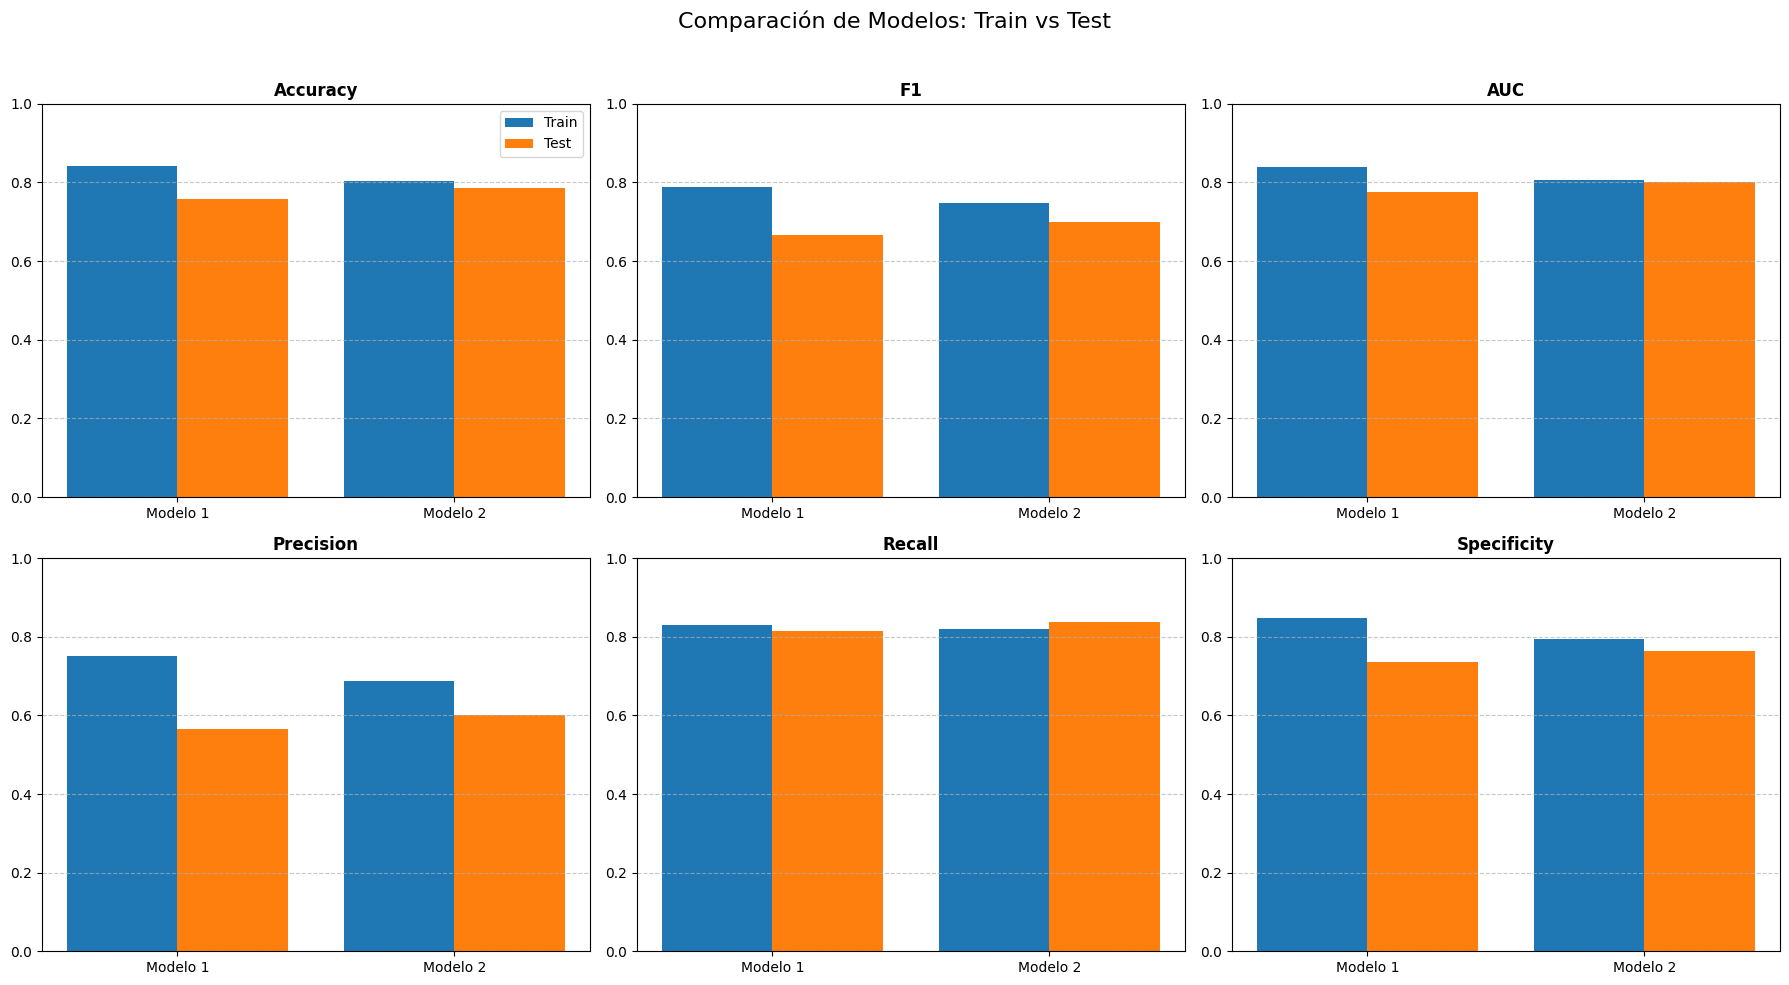

In [16]:
# Datos
metrics = ['Accuracy', 'F1', 'AUC', 'Precision', 'Recall', 'Specificity']
model1_train = [0.841105, 0.788018, 0.838641, 0.750000, 0.830097, 0.847185]
model1_test = [0.758621, 0.666667, 0.774624, 0.564516, 0.813953, 0.735294]
model2_train = [0.803109, 0.747788, 0.806977, 0.686992, 0.820388, 0.793566]
model2_test = [0.786207, 0.699029, 0.800958, 0.600000, 0.837209, 0.764706]

# Configuración de gráficos
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Comparación de Modelos: Train vs Test', fontsize=16)

for i, metric in enumerate(metrics):
    row, col = i // 3, i % 3
    ax = axs[row, col]
    
    # Posiciones y anchos de barras
    x = np.arange(2)  # Modelo 1 y Modelo 2
    width = 0.4
    
    # Barras para Train y Test
    bars1 = ax.bar(x - width/2, [model1_train[i], model2_train[i]], width, label='Train')
    bars2 = ax.bar(x + width/2, [model1_test[i], model2_test[i]], width, label='Test')
    
    # Etiquetas y formato
    ax.set_title(metric, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(['Modelo 1', 'Modelo 2'])
    ax.set_ylim(0, 1)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    

axs[0, 0].legend(loc='upper right')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Cada gráfico muestra barras agrupadas para comparar Train y Test de ambos modelos.

Las barras azules (Train) y naranjas (Test) permiten visualizar rápidamente las brechas de rendimiento y la consistencia de cada modelo.

# Guardado de Modelos

In [17]:
# Guardamos el modelo
from pickle import dump

dump(modeloALG, open("../models/CustomBoosting.sav", "wb"))
dump(best_xgb, open("../models/Xgb_mejorado.sav", "wb"))

# Conclusiones

El Modelo XGB es claramente superior en generalización y estabilidad, con menor sobreajuste y métricas más consistentes.

Sin embargo, si el contexto requiere priorizar la precisión (evitar falsos positivos), ambos modelos necesitarían ajustes.

Para la mayoría de escenarios, el Modelo XGB es más confiable por su robustez y mejor AUC.